In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score
import hashlib
import joblib
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Function to hash categorical values
def hash_value(val, max_hash=1e6):
    """Convert a value into a numerical hash."""
    return int(hashlib.md5(val.encode()).hexdigest(), 16) % int(max_hash)

In [3]:
# Load the dataset
file_path = 'updated_threshold_dataset.csv'  # Replace with your updated dataset path
data = pd.read_csv(file_path)

In [4]:
data.head()

,Plaintext,Encryption Key,EM Traces,EM Traces Parsed,Mean,Vulnerable
0,349E04B2220E9A91,A1B2C3D4E5F6G7H8,-0.009514566014924373 -0.013724001130807649 0....,[-9.51456601e-03 -1.37240011e-02 9.40345748e-...,0.400095,Yes
1,A2F2754A2108F98C,A1B2C3D4E5F6G7H8,0.8265974554480917 -0.0022728964945716327 1.04...,[ 8.26597455e-01 -2.27289649e-03 1.04838646e+...,0.431035,Yes
2,849FDDE3562B9557,A1B2C3D4E5F6G7H8,0.9491871434842741 0.010542504140883592 -0.014...,[ 0.94918714 0.0105425 -0.0146862 -0.017817...,0.578879,Yes
3,B9E8D649CFA1FDE9,A1B2C3D4E5F6G7H8,1.1091254985041068 -0.02510950551865237 0.9475...,[ 1.10912550e+00 -2.51095055e-02 9.47545198e-...,0.587255,Yes
4,DEBABE8B19439802,A1B2C3D4E5F6G7H8,0.9614286591451993 1.042765620205207 0.0131377...,[ 0.96142866 1.04276562 0.01313774 0.969699...,0.497083,No


In [5]:
# Add Mean column as a feature
if 'Mean' not in data.columns:
    data['EM Traces Parsed'] = data['EM Traces'].apply(
        lambda x: np.array([float(val) for val in x.split()])
    )
    data['Mean'] = data['EM Traces Parsed'].apply(np.mean)

In [6]:
# Encode Vulnerable as binary for easier analysis
data['Vulnerable Binary'] = data['Vulnerable'].map({'Yes': 1, 'No': 0})

# Basic Information and Summary
print("\nBasic Information:")
print(data.info())
print("\nSummary Statistics:")
print(data.describe())


Basic Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Plaintext          100 non-null    object 
 1   Encryption Key     100 non-null    object 
 2   EM Traces          100 non-null    object 
 3   EM Traces Parsed   100 non-null    object 
 4   Mean               100 non-null    float64
 5   Vulnerable         100 non-null    object 
 6   Vulnerable Binary  100 non-null    int64  
dtypes: float64(1), int64(1), object(5)
memory usage: 5.6+ KB
None

Summary Statistics:
             Mean  Vulnerable Binary
count  100.000000         100.000000
mean     0.490483           0.500000
std      0.062957           0.502519
min      0.353867           0.000000
25%      0.445648           0.000000
50%      0.497525           0.500000
75%      0.534636           1.000000
max      0.630172           1.000000


In [7]:
# Check for missing values
print("\nMissing Values:")
print(data.isnull().sum())


Missing Values:
Plaintext            0
Encryption Key       0
EM Traces            0
EM Traces Parsed     0
Mean                 0
Vulnerable           0
Vulnerable Binary    0
dtype: int64


C:\conda_tmp\ipykernel_16592\1755522601.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=data, x='Vulnerable', palette='Set2')


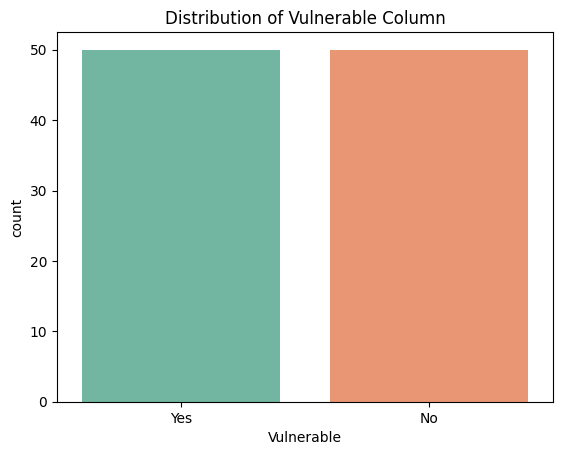

In [8]:
# Distribution of Target Variable
sns.countplot(data=data, x='Vulnerable', palette='Set2')
plt.title("Distribution of Vulnerable Column")
plt.show()

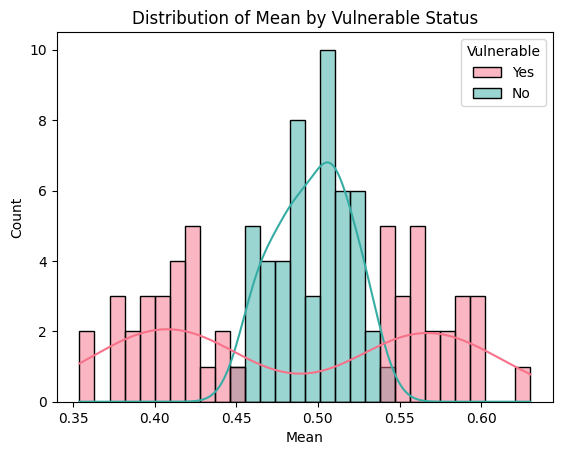

In [9]:
# Mean Distribution for Vulnerable vs Not Vulnerable
sns.histplot(data=data, x='Mean', hue='Vulnerable', kde=True, palette='husl', bins=30)
plt.title("Distribution of Mean by Vulnerable Status")
plt.show()

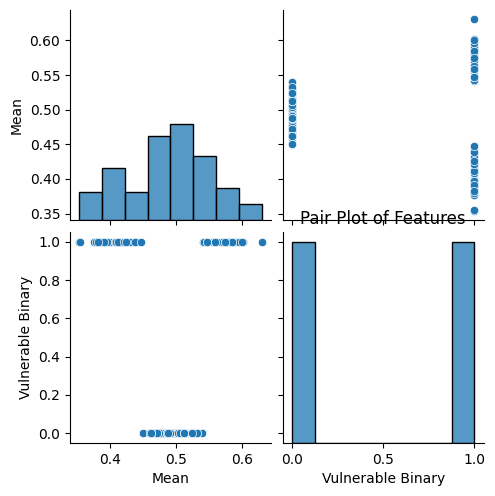

In [10]:
# Pair Plot for Numerical Features
sns.pairplot(data[['Mean', 'Vulnerable Binary']])
plt.title("Pair Plot of Features")
plt.show()

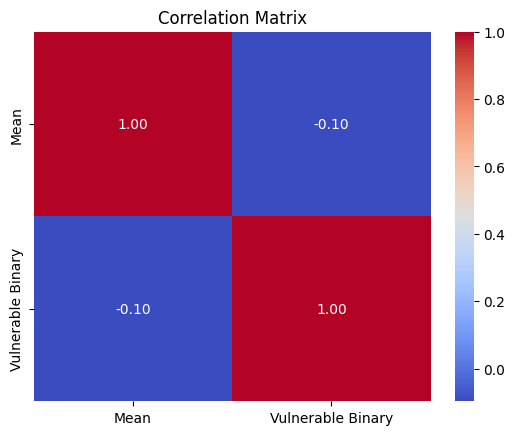

In [11]:
# Correlation Matrix
correlation_matrix = data[['Mean', 'Vulnerable Binary']].corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title("Correlation Matrix")
plt.show()

In [12]:
# Apply hash encoding to Plaintext and Encryption Key
data['Plaintext Hashed'] = data['Plaintext'].apply(lambda x: hash_value(x))
data['Encryption Key Hashed'] = data['Encryption Key'].apply(lambda x: hash_value(x))

In [13]:
# Prepare features (X) and target (y)
X = data[['Plaintext Hashed', 'Encryption Key Hashed', 'Mean']].values
y = data['Vulnerable'].map({'Yes': 1, 'No': 0})  # Convert class variable to binary

In [14]:
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [15]:
# Initialize models
models = {
    "Random Forest": RandomForestClassifier(random_state=42),
    "Support Vector Machine": SVC(kernel='linear', random_state=42),
    "Logistic Regression": LogisticRegression(random_state=42),
    "K-Nearest Neighbors": KNeighborsClassifier(n_neighbors=5)
}

In [16]:
# Train and evaluate models
best_model = None
best_accuracy = 0
results = {}

for model_name, model in models.items():
    # Train the model
    model.fit(X_train, y_train)
    
    # Make predictions
    y_pred = model.predict(X_test)
    
    # Calculate accuracy
    accuracy = accuracy_score(y_test, y_pred)
    results[model_name] = accuracy
    
    # Update the best model
    if accuracy > best_accuracy:
        best_model = model
        best_accuracy = accuracy

In [17]:
# Save the best model
best_model_file = 'best_model.pkl'
joblib.dump(best_model, best_model_file)

['best_model.pkl']

In [18]:
# Print results
print("Model Accuracies:")
for model_name, accuracy in results.items():
    print(f"{model_name}: {accuracy:.4f}")

Model Accuracies:
Random Forest: 0.9500
Support Vector Machine: 0.5000
Logistic Regression: 0.6500
K-Nearest Neighbors: 0.6500


In [19]:
print(f"\nBest model: {best_model.__class__.__name__} with accuracy {best_accuracy:.4f}")
print(f"Best model saved as {best_model_file}")


Best model: RandomForestClassifier with accuracy 0.9500
Best model saved as best_model.pkl


In [20]:
# Extract model names and accuracies
model_names = list(results.keys())
accuracies = list(results.values())

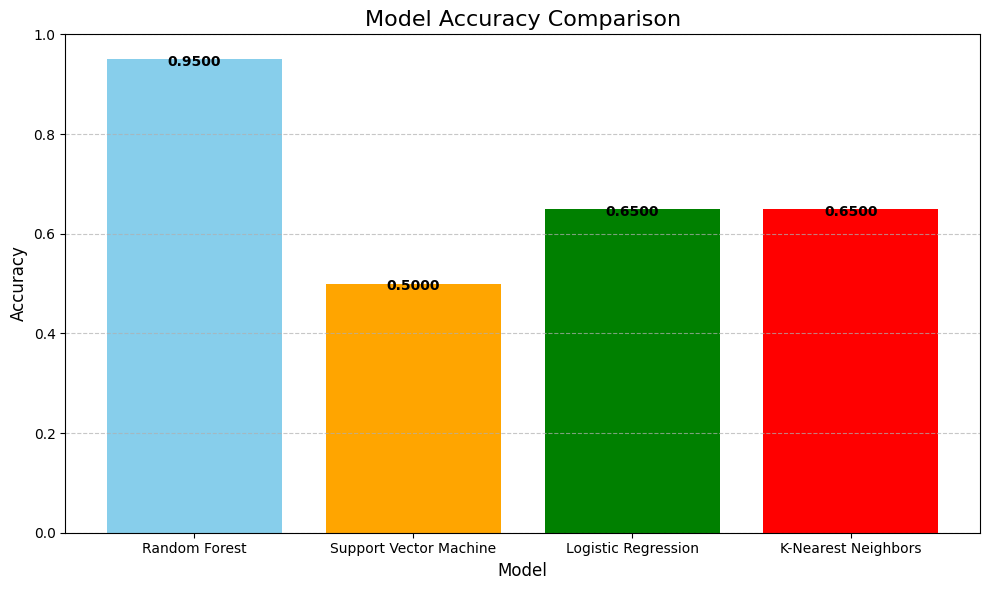

In [21]:
# Create the bar plot
plt.figure(figsize=(10, 6))
bars = plt.bar(model_names, accuracies, color=['skyblue', 'orange', 'green', 'red'])

# Annotate each bar with accuracy values
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height() - 0.02,
             f"{bar.get_height():.4f}",
             ha='center', va='bottom', fontsize=10, color='black', weight='bold')

# Add labels and title
plt.title("Model Accuracy Comparison", fontsize=16)
plt.xlabel("Model", fontsize=12)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0, 1)  # Set y-axis range from 0 to 1
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Show the plot
plt.tight_layout()
plt.show()